In [ ]:
############# MF CF IMPLEMMENTATION FROM SCRATCH ##############

# Simulated user-item rating matrix
# Rows: users
# Columns: items
# 0 indicates missing values
R_df = pd.read_parquet("dataset/adj_matrix_contract_names.parquet")
R = R_df.values

# Initialize parameters
num_users, num_items = R.shape
num_features = 3  # Number of latent features
learning_rate = 0.01  # Learning rate
regularization = 0.01  # Regularization parameter
num_epochs = 100  # Number of epochs

# Initialize user and item matrices with random values
U = np.random.randn(num_users, num_features)
I = np.random.randn(num_items, num_features)

print('1')
# Training
for epoch in tqdm(range(num_epochs), total = num_epochs):
    for i in range(num_users):
        for j in range(num_items):
            if R[i][j] > 0:
                # Compute error
                eij = R[i][j] - np.dot(U[i, :], I[j, :].T)
                
                # Update matrices
                for k in range(num_features):
                    U[i][k] += learning_rate * (2 * eij * I[j][k] - regularization * U[i][k])
                    I[j][k] += learning_rate * (2 * eij * U[i][k] - regularization * I[j][k])
    
    print('2')
    # Compute total error
    error = 0
    for i in range(num_users):
        for j in range(num_items):
            if R[i][j] > 0:
                error += (R[i][j] - np.dot(U[i, :], I[j, :].T)) ** 2
                for k in range(num_features):
                    error += (regularization / 2) * (U[i][k] ** 2 + I[j][k] ** 2)
    print('3')
    # print(f"Epoch {epoch + 1}/{num_epochs} - Error: {error}")

# Create the prediction matrix
prediction = np.dot(U, I.T)

# print("Prediction matrix:")
# print(prediction)

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k]
    return np.mean(r)

def average_precision(r, k):
    r = np.asarray(r)[:k]
    out = [precision_at_k(r, j + 1) for j, rel in enumerate(r) if rel]
    if not out:
        return 0
    return np.mean(out)

def mean_average_precision(rs, k):
    return np.mean([average_precision(r, k) for r in rs])

# Assume these are your predicted ratings
predicted_ratings = prediction

# Assume these are your true binary relevance scores (e.g., 1 if relevant, 0 otherwise)
true_relevance = pd.read_parquet("dataset/adj_matrix_contract_names.parquet")

# Convert predicted ratings to binary relevance scores based on a threshold (optional)
predicted_relevance = (predicted_ratings > 0.5).astype(int)

# Sort the true relevance labels based on predicted ratings (higher ratings are assumed to be more relevant)
sorted_relevance = []
for i in range(predicted_ratings.shape[0]):
    sorted_relevance.append(true_relevance[i, np.argsort(predicted_ratings[i])[::-1]])

# Calculate MAP@K
K = 5
result = mean_average_precision(sorted_relevance, K)
print(f"MAP@{K}: {result}")

In [ ]:
################# PRECISION & RECALL EVAL ######################
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''
    precisions = dict()
    recalls = dict()
    user_est_true = defaultdict(list)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings) 
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k]) 
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0 

    return precisions, recalls, k

run a simpler ranker, just based on contract's deployer name (find a simple dataset of names: tag), 
recommend the highest interactable tags, but report how many contracts within our dataset would be ignored 
as limitation. Run the topic modeling somehow and build the adjacancy matrix
write a script that send the contract to a GPT model, hardcode a taxonomy, 
fetch GPT's opinion regarding which taxonomy tags the contract belongs to 
(somehow should solve the context limit if using Llma2)
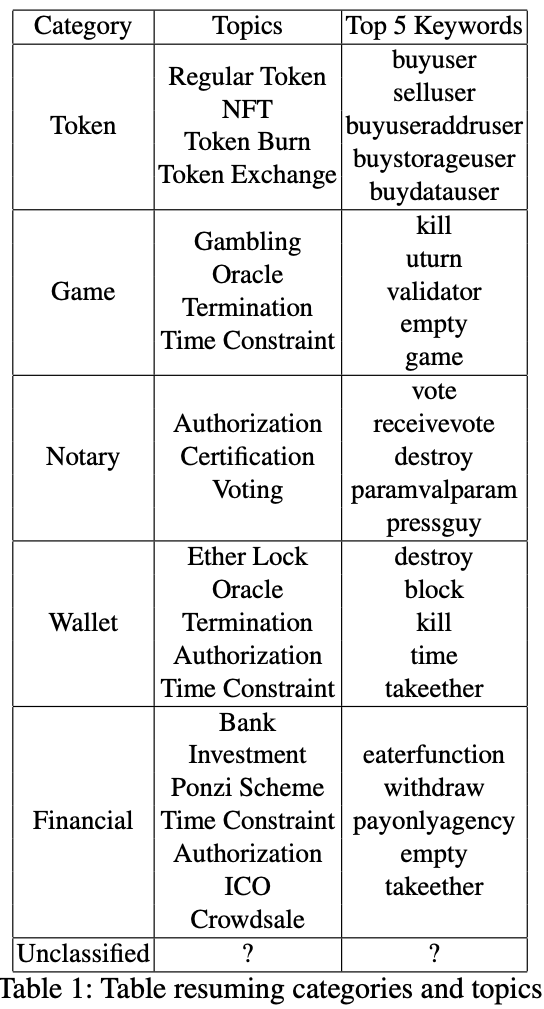

In [ ]:
############## CONTRACT RAW CODE LEVEL LDA ############
##################### FETCH CONTRACTS, TOPIC MODELING OVER CONTRACTS RAW CODES #####################

'''
Step 1: create a dataset of all contracts that users had interactions with in user_transaction.csv dataset (address: source_code)
Step 2: run the pre processors to remove stop words, and lowercase all words, then run the LDA topic modeling with 15 as categories
Step 3: create an adjacancy matrix with user addresses as rows and topics from LDA as columns (create a zero matrix, going over each tx,
 the pass the dest to topic_checker, put 1 if the tx exists)
 '''

def fetch_contract_code(contract_address):
    
    API_KEYS = [
    "D2QM9JPD6UMK1XYCTK32SE9IRZCP8BF1AG",
    "AWCSTEYS9UFUUBFV93VMI515KM76GDD64M",
    "GQCU175SEDHUYD5XPBB612Z82A1FUG7AJE",
    "JSIA3K7IY1KIZMENRKNF68APJGX94HTGXF",
    "569PCB1XJH8YBFWPCPNPGGXXZZ1UVUHCTR",
    "BH636KQJA859VI1NMFZZZ2QBP8AK4SI2F3",
    "8R8Q31PKGGXMDQW1XZEZUASWEYB5GIQ4UU",
    "ERT6MCD5DURIGP4A7IKRWRVK27WUMG15UW",
    "9XJA73YK99XBGXN6ATNBXDAEQUREC2N8DD",
    "APNH5S9WU2JSQCYJKAR1IVKTW82V1EXMVJ"
    ]

    url = 'https://api.etherscan.io/api'

    api_key = random.choice(API_KEYS)

    # Parameters
    payload = {
        'module': 'contract',
        'action': 'getsourcecode',
        'address': contract_address,
        'apikey': api_key
    }

    response = requests.get(url, params=payload)
    if response.status_code == 200:
        data = response.json()
        # Return the contract code
        return data['result'][0]['SourceCode']
    else:
        print(f'Error: {response.status_code}')
        return None
    
user_tx = pd.read_csv('dataset/user_transactions.csv')
all_contract_addresses = pd.read_csv('dataset/contract_addresses.csv')
unique_addresses = pd.concat([user_tx['address'], user_tx['from'], user_tx['to']]).unique()
all_contract_addresses_set = set(all_contract_addresses['address'])
contract_addresses = [address for address in unique_addresses if address in all_contract_addresses_set]
contract_addresses = pd.Series(contract_addresses).reset_index(drop=True)
contract_addresses_set = set(contract_addresses)

processed_addresses = set()
json_file = 'dataset/contracts_code.json'

# Load already processed addresses
try:
    with open(json_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            processed_addresses.add(data['address'])
except FileNotFoundError:
    pass

# Get the remaining addresses that have not been processed
remaining_addresses = [address for address in contract_addresses if address not in processed_addresses]

# Initialize a list to keep track of skipped addresses
skipped_addresses = []

# Fetch source code for remaining addresses and update the JSON file
with open(json_file, 'a') as f:  # Use 'a' (append mode) to update the file
    for address in tqdm(remaining_addresses, desc='Fetching contract source codes'):
        try:
            source_code = fetch_contract_code(address)
            if source_code:
                data = {
                    'address': address,
                    'source_code': source_code 
                }
                json.dump(data, f)
                f.write('\n')
        except Exception as e:
            print(f"Skipped address {address} due to error: {str(e)}")
            skipped_addresses.append(address)


In [ ]:
# Step 2: run the pre processors to remove stop words, and lowercase all words, then run the LDA topic modeling with 15 as categories

# Load your contracts into a list
contracts = set()
json_file = 'dataset/contracts_code.json'

# Load already processed addresses
with open(json_file, 'r') as f:
    for line in f:
        data = json.loads(line)
        contracts.add(data['source_code'])

# # aggressive pre-processors
# CUSTOM_FILTERS = [lambda x: x.lower(), split_alphanum, strip_tags, strip_punctuation, strip_numeric, stem_text, remove_stopwords]

# TODO: run with this preprocessor and compare the LDA topic modeling output, Soft pre-processors
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation]

# Apply preprocessing
processed_contracts = [preprocess_string(contract, CUSTOM_FILTERS) for contract in contracts]

# Create the dictionary and corpus required for LDA
dictionary = corpora.Dictionary(processed_contracts)
corpus = [dictionary.doc2bow(contract) for contract in processed_contracts]

# Run the LDA model
num_topics = 15  # Choose an appropriate number
lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Print the topics
for i in range(num_topics):
    print(f"Topic #{i}: ", lda.print_topic(i))

##################################RESULTS####################################
# Topic #0:  0.262*"u" + 0.072*"e" + 0.046*"c" + 0.042*"tokenid" + 0.021*"uint" + 0.020*"id" + 0.012*"delet" + 0.011*"owner" + 0.010*"s" + 0.009*"token"
# Topic #1:  0.060*"set" + 0.058*"return" + 0.053*"valu" + 0.035*"uint" + 0.030*"byte" + 0.028*"function" + 0.025*"index" + 0.020*"dev" + 0.019*"map" + 0.019*"address"
# Topic #2:  0.049*"address" + 0.035*"return" + 0.033*"tokenid" + 0.031*"function" + 0.027*"uint" + 0.025*"dev" + 0.023*"token" + 0.021*"contract" + 0.020*"owner" + 0.018*"byte"
# Topic #3:  0.070*"uint" + 0.052*"address" + 0.030*"return" + 0.029*"function" + 0.027*"token" + 0.023*"param" + 0.023*"public" + 0.018*"msg" + 0.016*"sender" + 0.015*"contract"
# Topic #4:  0.041*"address" + 0.038*"return" + 0.036*"uint" + 0.030*"function" + 0.024*"owner" + 0.024*"token" + 0.022*"tokenid" + 0.019*"dev" + 0.013*"view" + 0.012*"contract"
# Topic #5:  0.262*"p" + 0.093*"t" + 0.073*"log" + 0.065*"bool" + 0.065*"address" + 0.065*"uint" + 0.064*"string" + 0.038*"view" + 0.038*"abi" + 0.038*"intern"
# Topic #6:  0.737*"n" + 0.012*"address" + 0.010*"return" + 0.009*"sol" + 0.008*"uint" + 0.007*"nimport" + 0.007*"function" + 0.007*"dev" + 0.006*"erc" + 0.006*"content"
# Topic #7:  0.049*"address" + 0.043*"return" + 0.037*"uint" + 0.031*"function" + 0.027*"dev" + 0.023*"token" + 0.021*"account" + 0.020*"requir" + 0.020*"zero" + 0.019*"allow"
# Topic #8:  0.046*"address" + 0.040*"return" + 0.034*"byte" + 0.034*"function" + 0.029*"memori" + 0.027*"target" + 0.025*"data" + 0.023*"contract" + 0.021*"valu" + 0.017*"intern"
# Topic #9:  0.065*"x" + 0.051*"b" + 0.050*"d" + 0.047*"e" + 0.046*"c" + 0.044*"f" + 0.020*"byte" + 0.017*"uint" + 0.014*"memori" + 0.014*"string"
# Topic #10:  0.044*"role" + 0.036*"byte" + 0.026*"account" + 0.021*"return" + 0.021*"function" + 0.019*"address" + 0.016*"signatur" + 0.016*"dev" + 0.015*"hash" + 0.015*"contract"
# Topic #11:  0.103*"n" + 0.030*"address" + 0.028*"uint" + 0.026*"return" + 0.022*"function" + 0.020*"byte" + 0.019*"memori" + 0.015*"contract" + 0.012*"string" + 0.012*"valu"
# Topic #12:  0.221*"t" + 0.033*"dev" + 0.019*"request" + 0.015*"seed" + 0.015*"random" + 0.014*"tfunction" + 0.013*"tuint" + 0.011*"param" + 0.011*"vrf" + 0.009*"s"
# Topic #13:  0.105*"uint" + 0.080*"address" + 0.047*"return" + 0.046*"function" + 0.027*"extern" + 0.019*"privat" + 0.018*"public" + 0.015*"bool" + 0.015*"owner" + 0.013*"view"
# Topic #14:  0.499*"r" + 0.385*"n" + 0.007*"uint" + 0.006*"address" + 0.005*"return" + 0.004*"function" + 0.003*"dev" + 0.003*"sol" + 0.002*"memori" + 0.002*"nimport"

In [ ]:
##################### RUN KMEAN CLUSTRING OVER CONTRACT RAW SOURCE CODE ######################
'''
One intersting way would be running a k-mean clustring algorithm to find k differetn clusters of contracts, 
then feed one of each category to a LLM to guess the category name
'''

contracts = []
json_file = 'dataset/contracts_code.json'

# Load already processed addresses
with open(json_file, 'r') as f:
    for line in f:
        data = json.loads(line)
        contracts.append((data['address'], data['source_code']))

# Define your preprocessors
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation]

# Apply preprocessing
processed_contracts = [' '.join(preprocess_string(source_code, CUSTOM_FILTERS)) for address, source_code in tqdm(contracts, desc="Preprocessing contracts")]




In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_contracts)

# Normalize the data to ensure that the magnitude of the vectors does not affect the performance of the k-means algorithm.
X = normalize(X)

# Run the K-means clustering
k = 5  # Choose an appropriate number
kmeans = KMeans(n_clusters=k, random_state=0)

print("Running K-means clustering...")
kmeans.fit(X)
tqdm.write("K-means clustering completed!")

# Print the cluster assignments
assignments = kmeans.predict(X)
for i in range(k):
    tqdm.write(f"Cluster #{i}: {assignments[assignments == i].shape[0]}")

In [ ]:
''' 
Cluster #0: 3268 -> Gaming
Cluster #1: 4613 -> Notary
Cluster #2: 9539 -> Financial
Cluster #3: 20496 -> Token
Cluster #4: 6382 -> wallet 
'''

# Transform the preprocessed contract into the TF-IDF feature space
X_new = vectorizer.transform([processed_contracts[1]])
X_new = normalize(X_new)
predicted_cluster = kmeans.predict(X_new)
print(f"The new contract belongs to cluster {predicted_cluster[0]}")

In [ ]:

contract_tags = []
processed_contracts_addresses = [(address, ' '.join(preprocess_string(source_code, CUSTOM_FILTERS))) for address, source_code in tqdm(contracts, desc="Preprocessing contracts with addresses")]


# Define the cluster-to-tag mapping
cluster_to_tag_mapping = {
    0: "Game",
    1: "Notary",
    2: "Financial",
    3: "Token",
    4: "wallet"
}

for (address, source_code) in processed_contracts_addresses:

    try:
        X = vectorizer.transform([source_code])
        X = normalize(X)
        # Predict the clusters
        predicted_cluster = kmeans.predict(X)
        contract_tags.append( (address, cluster_to_tag_mapping[predicted_cluster[0]]) )
    except Exception as e:
        print(" skipped contract: ", str(e))



# Convert to a pandas DataFrame
df = pd.DataFrame(contract_tags, columns=['address', 'tag'])

# Save to CSV
df.to_csv('dataset/contract_tags.csv', index=False)

In [ ]:
################## CREATE USER_TX ADJ MATRIX WITH CONTRACT KMEAN TAGS ####################

'''
create users-txs matrix with [len(unique_eoa_addresses), 50], 
put 0 to 4 for each tx(i.e., interactions), 
then try to predict the next category user will interact with (time-based spilit for inference)
'''

user_tx = pd.read_csv('dataset/user_transactions.csv')

all_contract_addresses_with_tag = pd.read_csv('dataset/contract_tags.csv')
all_contract_addresses_with_tag_set = set(all_contract_addresses_with_tag['address'])

unique_addresses = pd.concat([user_tx['address'], user_tx['from'], user_tx['to']]).unique()

contract_addresses_with_tag = [address for address in unique_addresses if address in all_contract_addresses_with_tag_set]
eoa_addresses = [address for address in unique_addresses if address not in all_contract_addresses_set]

# Create a DataFrame with addresses as index and 50 columns for transactions
df = pd.DataFrame(-1, index=eoa_addresses, columns=[f'tx_{i+1}' for i in range(50)])
df.index.name = 'address'

# Create a dictionary mapping tags to integers
tag_mapping = {
    'Game': 0,
    'Notary': 1,
    'Financial': 2,
    'Token': 3,
    'wallet': 4
}

# Convert contract_with_tag to a dictionary for faster lookup
contract_dict = all_contract_addresses_with_tag.set_index('address')['tag'].to_dict()

for i, row in user_tx.iterrows():
    tx_from = row['from']
    tx_to = row['to']

    if tx_from in eoa_addresses and tx_to in contract_dict:
        user_address = tx_from
        contract_address = tx_to
        tag = contract_dict[contract_address]
        tag_int = tag_mapping[tag]
        col_name = df.columns[df.loc[user_address, :] == -1][0]
        df.loc[user_address, col_name] = tag_int

    if tx_from in contract_dict and tx_to in eoa_addresses:
        user_address = tx_to
        contract_address = tx_from
        tag = contract_dict[contract_address]
        tag_int = tag_mapping[tag]
        col_name = df.columns[df.loc[user_address, :] == -1][0]
        df.loc[user_address, col_name] = tag_int
    
df.to_csv('dataset/adj_matrix_kmean_tags.csv', index=True)

In [ ]:
############ MAP@K IMPLEMEMNTATION WITH LATENT FACTOR MATRIX MUL #############

def average_precision_at_k(k, predicted, true_rated):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in true_rated:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if len(true_rated) == 0:
        return 0.0

    return score / min(len(true_rated), k)

# Create a dataframe with user-item ratings
data = pd.read_parquet('dataset/user_contract_rating.parquet')
data = data[:10000]
###### DATA PREPROCESSING #######
def apply_rating_scale(rating):
    if rating == 1:
        return 1
    elif rating <= 5:
        return 2
    elif rating <= 15:
        return 3
    elif rating <= 30:
        return 4
    else:
        return 5
data['rating'] = data['rating'].apply(apply_rating_scale)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data, reader)
trainset = data.build_full_trainset()

# Train the model
model = SVD()
model.fit(trainset)

# Extract latent factors
user_factors = model.pu
item_factors = model.qi

# Predict ratings
predicted_ratings = np.dot(user_factors, item_factors.T)

# Test set
_, testset = train_test_split(data, test_size=0.2)

# Calculate MAP@K
k = 20
mapk_values = []

for uid, iid, true_r in testset:
    inner_uid = trainset.to_inner_uid(uid)
    inner_iid = trainset.to_inner_iid(iid)

    # Get predicted ratings for this user
    user_predicted_ratings = predicted_ratings[inner_uid]

    # Get top-k item indexes
    top_k_items = np.argsort(user_predicted_ratings)[::-1][:k]

    # Map inner ids of items to raw ids
    top_k_items_raw_ids = [trainset.to_raw_iid(inner_id) for inner_id in top_k_items]

    # Get the list of true positive items for this user in the test set
    true_positive_items = [j for (u, j, _) in testset if u == uid]

    # Calculate AP@K for this user
    apk = average_precision_at_k(k, top_k_items_raw_ids, set(true_positive_items))
    mapk_values.append(apk)

# Calculate the mean AP@K over all users
MAPK = np.mean(mapk_values)
print(f"MAP@K: {MAPK}")

In [ ]:
# MOVED LATEST VERSION OF BELOW CODE TO vf_recommender/cf_recommender_name_level.py

############# RUNNING BASELINE RECOMMENDERS ###############
data = pd.read_parquet('dataset/user_contract_rating.parquet')
data = data[:100000]
###### DATA PREPROCESSING #######
def apply_rating_scale(rating):
    if rating == 1:
        return 1
    elif rating <= 5:
        return 2
    elif rating <= 15:
        return 3
    elif rating <= 30:
        return 4
    else:
        return 5
data['rating'] = data['rating'].apply(apply_rating_scale)


################# AUTO-EVAL SVD CF #####################
# algo = SVD()
# print('cf started')
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

################# AUTO-EVAL KNN CF #####################
# sim_options = {
#     'name': 'cosine',
#     'user_based': True
# }
# algo = KNNBasic(sim_options=sim_options)
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

#################### CF RECOMMENDER #######################
'''The average percision just tell us how relevant our recommendations are, 
    but dosn't tell us how good our ranking is
'''
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(data[['user', 'item', 'rating']], reader)
# data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.2)
print(trainset.n_users)
model = SVD()
model.fit(trainset)
K_values = [1, 5, 10, 15, 20]
predictions = model.test(testset)
print(len(predictions))

################### MAP@K EVAL WITH MODEL.TEST ######################
for K in K_values:
    user_est_true = defaultdict(list)
    user_actual_items = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((iid, est))
        user_actual_items[uid].append(iid)

    # Compute custom MAP@K
    mapk_sum = 0.0
    num_users = 0

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[1], reverse=True)

        # Get the top-K recommended items
        top_k_items = [iid for iid, _ in user_ratings[:K]]
        
        # Get the actual items the user has interacted with
        actual_items = user_actual_items.get(uid, [])
        
        # Compute the intersection of top-K and actual items
        num_hits = len(set(top_k_items) & set(actual_items))
        
        # Avoid division by zero
        if len(actual_items) == 0:
            continue

        # Compute Average Precision@K for this user
        apk = num_hits / len(top_k_items)
        
        # Update MAP@K
        mapk_sum += apk
        num_users += 1

    mapk = mapk_sum / num_users
    print(f"Custom MAP@{K}: {mapk}")

############# POPULAR CONTRACT RECOMMENDER ###############
# def MAP_at_K_PCR(data=None, K=None):
#     total_map = 0.0
#     count_users = 0
    
#     for user in data['user'].unique():
#         true_items = data[data['user'] == user]['item'].tolist()
#         if len(true_items) == 0:
#             continue
        
#         predicted_items = data.groupby('item')['rating'].sum().sort_values(ascending=False).head(K).index.tolist()
#         hits = 0
#         sum_precisions = 0.0
#         for k in range(1, K+1):
#             item_at_k = predicted_items[k - 1]
#             if item_at_k in true_items:
#                 hits += 1
#                 precision_at_k = hits / k
#                 sum_precisions += precision_at_k
                
#         average_precision = sum_precisions / min(len(true_items), K)
#         total_map += average_precision
#         count_users += 1
    
#     MAP_at_K = total_map / count_users if count_users > 0 else 0
#     return MAP_at_K

# with ThreadPoolExecutor() as executor:
#     K_values = [1, 5, 10, 15, 20]
#     futures = {executor.submit(MAP_at_K_PCR, data=data, K=k): k for k in K_values}

#     for future in as_completed(futures):
#         k = futures[future]
#         try:
#             map_result = future.result()
#             print(f'MAP @ {k}: {map_result}')
#         except Exception as e:
#             print(f'Failed to compute MAP @ {k} due to {e}')


